# Многоклассовая классификация. Метод ближайших соседей. Метод опорных векторов. Отбор признаков.

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Введение в ML ITHUB/lessons/data/zayavki.csv')
df.head()

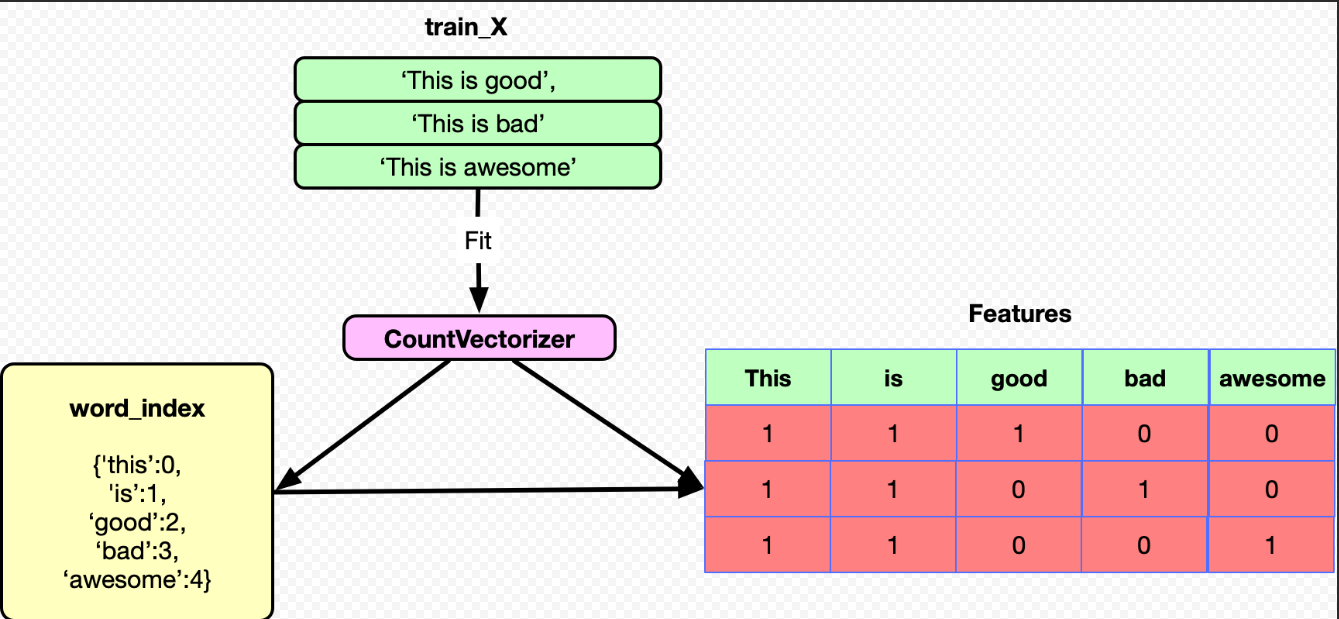

In [ ]:
df['category'].value_counts()

Сегодня решаем задачу мультиномиальной классификации - прогнозируем категорию заявки

In [ ]:
X=df.drop(['category','id_category'],axis=1)
Y=df['id_category']

In [ ]:
#логистическая регрессия
model_lr = LogisticRegression(multi_class='multinomial',max_iter=10000)
cv_results = cross_validate(model_lr, X[:10000], Y[:10000], cv=5,scoring='accuracy')

In [ ]:
cv_results['test_score'].mean()

## Метод ближайшего соседа (KNeighborsClassifier)



Что это такое?
На интуитивном уровне суть метода проста: посмотри на соседей вокруг, какие из них преобладают, таковым ты и являешься. Формально основой метода является гипотеза компактности: если метрика расстояния между примерами введена удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных.

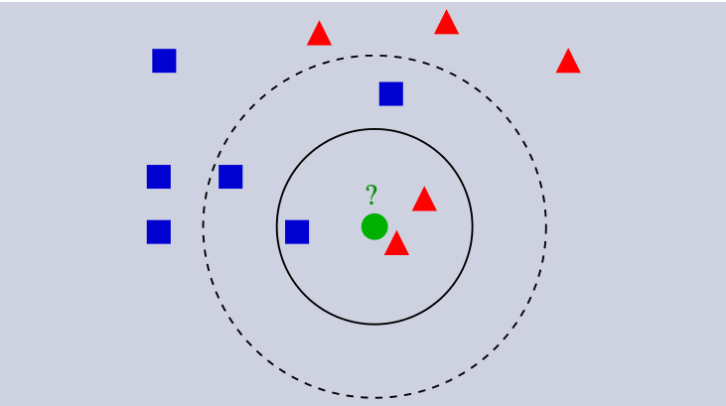

* У нас есть тестовый образец в виде зеленого круга. Синие квадраты мы обозначим как класс 1, красные треугольники – класс 2.
* Зеленый круг должен быть классифицирован как класс 1 или класс 2. Если рассматриваемая нами область является малым кругом, то объект классифицируется как 2-й класс, потому что внутри данного круга 2 треугольника и только 1 квадрат.
* Если мы рассматриваем большой круг (с пунктиром), то круг будет классифицирован как 1-й класс, так как внутри круга 3 квадрата в противовес 2 треугольникам.

In [6]:
model_kn = KNeighborsClassifier(n_neighbors = 10)
cv_results = cross_validate(model_kn, X[:10000], Y[:10000], cv=5,scoring='accuracy')
cv_results['test_score'].mean()

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


0.6397

Документация sklearn - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [7]:
#потюним модель с соседями
import warnings 
warnings.filterwarnings('ignore')
n_neighbors = range(1, 23, 3)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
for n in n_neighbors:
  for w in weights:
    for m in metric:
      model_kn=KNeighborsClassifier(n_neighbors = n,weights=w, metric=m)
      cv_results = cross_validate(model_kn, X[:10000], Y[:10000], cv=5,scoring='accuracy')
      print(n,w,m,f'={cv_results["test_score"].mean()}')

1 uniform euclidean =0.6115
1 uniform manhattan =0.6095
1 uniform minkowski =0.6115
1 distance euclidean =0.6115


KeyboardInterrupt: ignored

## Метод опорных векторов (SVM, Support Vector Machine)

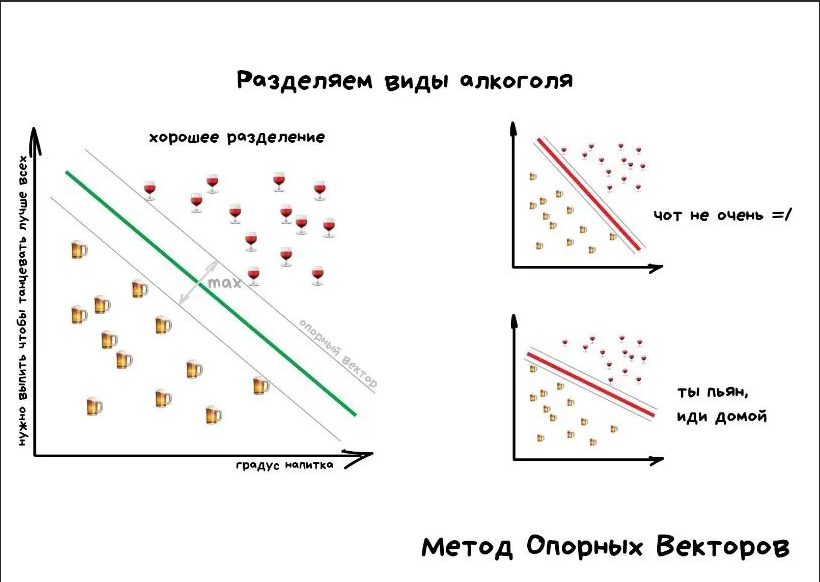

Работа с опорными векторными машинами (SVM) очень проста, цель состоит в том, чтобы создать гиперплоскость, которая разделяет набор данных на разные классы.

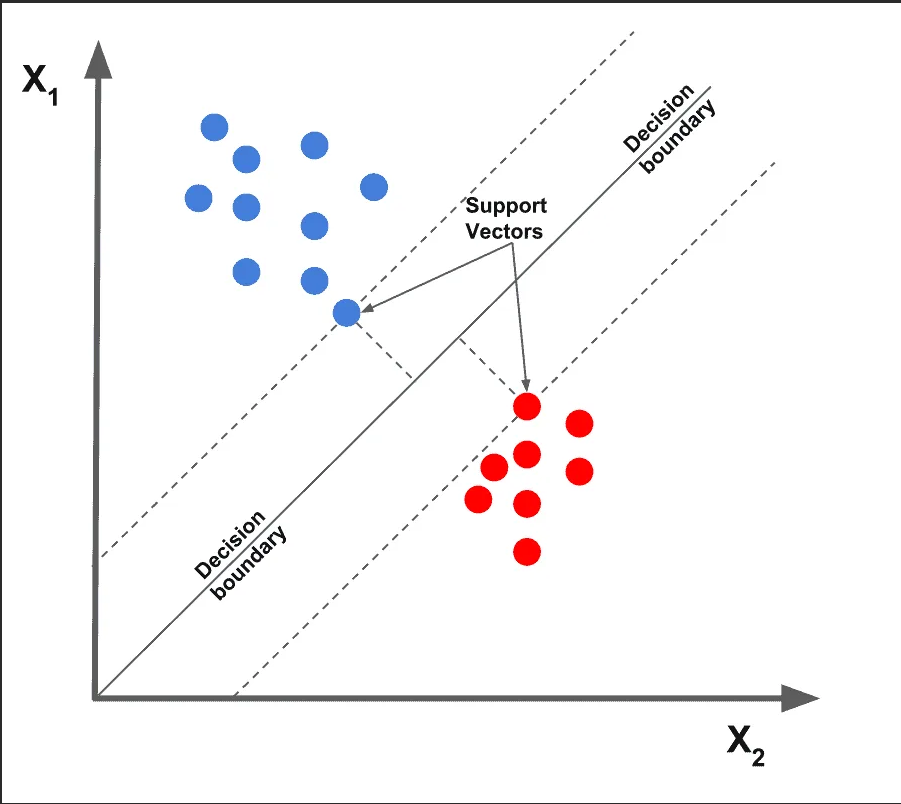

In [8]:
model_smc = SVC()
cv_results = cross_validate(model_smc, X[:10000], Y[:10000], cv=5,scoring='accuracy')
cv_results['test_score'].mean()

0.7081

In [ ]:
#параметры для тюнинга
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

## Глянем метрики

In [10]:
final_model=KNeighborsClassifier(n_neighbors = 20)

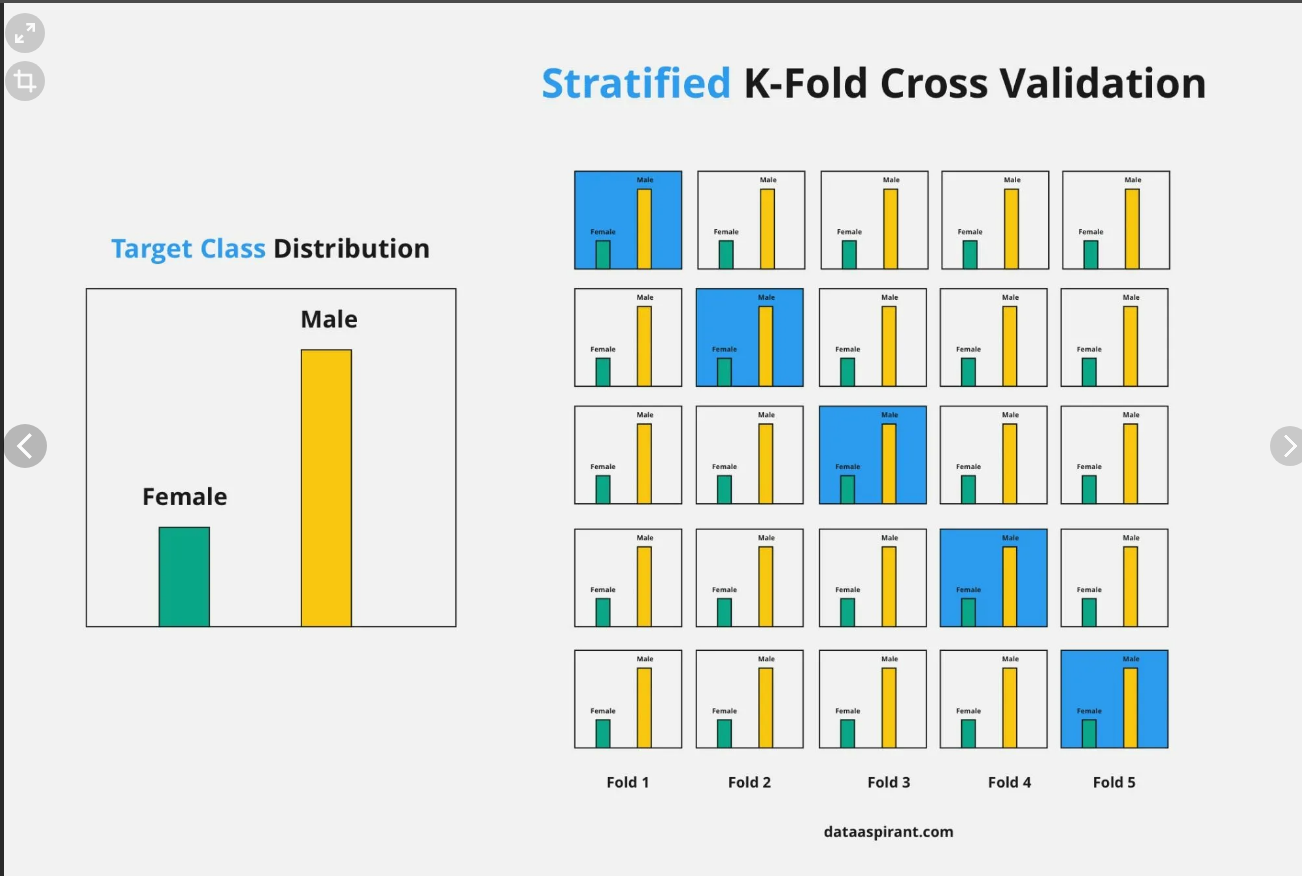

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
final_model.fit(X_train,y_train)
y_pred=final_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.83      0.07      0.13        72
           2       0.66      0.81      0.73      4523
           3       0.68      0.65      0.67      2952
           4       0.70      0.48      0.56       303
           7       0.42      0.08      0.13        66
           8       0.72      0.57      0.64       248
          10       0.87      0.83      0.85      4036
          11       0.82      0.28      0.42       130
          14       0.00      0.00      0.00        12
          15       0.88      0.83      0.86       176
          16       0.00      0.00      0.00        14
          17       0.71      0.06      0.11       210
          19       0.58      0.82      0.68      1099
          21       0.71      0.52      0.60       445
          23       0.79      0.78      0.78       651
          28       0.00      0.00      0.00        23
          29       0.00      0.00      0.00        22
          37       0.90    

In [ ]:
len(y_pred)

Разница precision and recall???

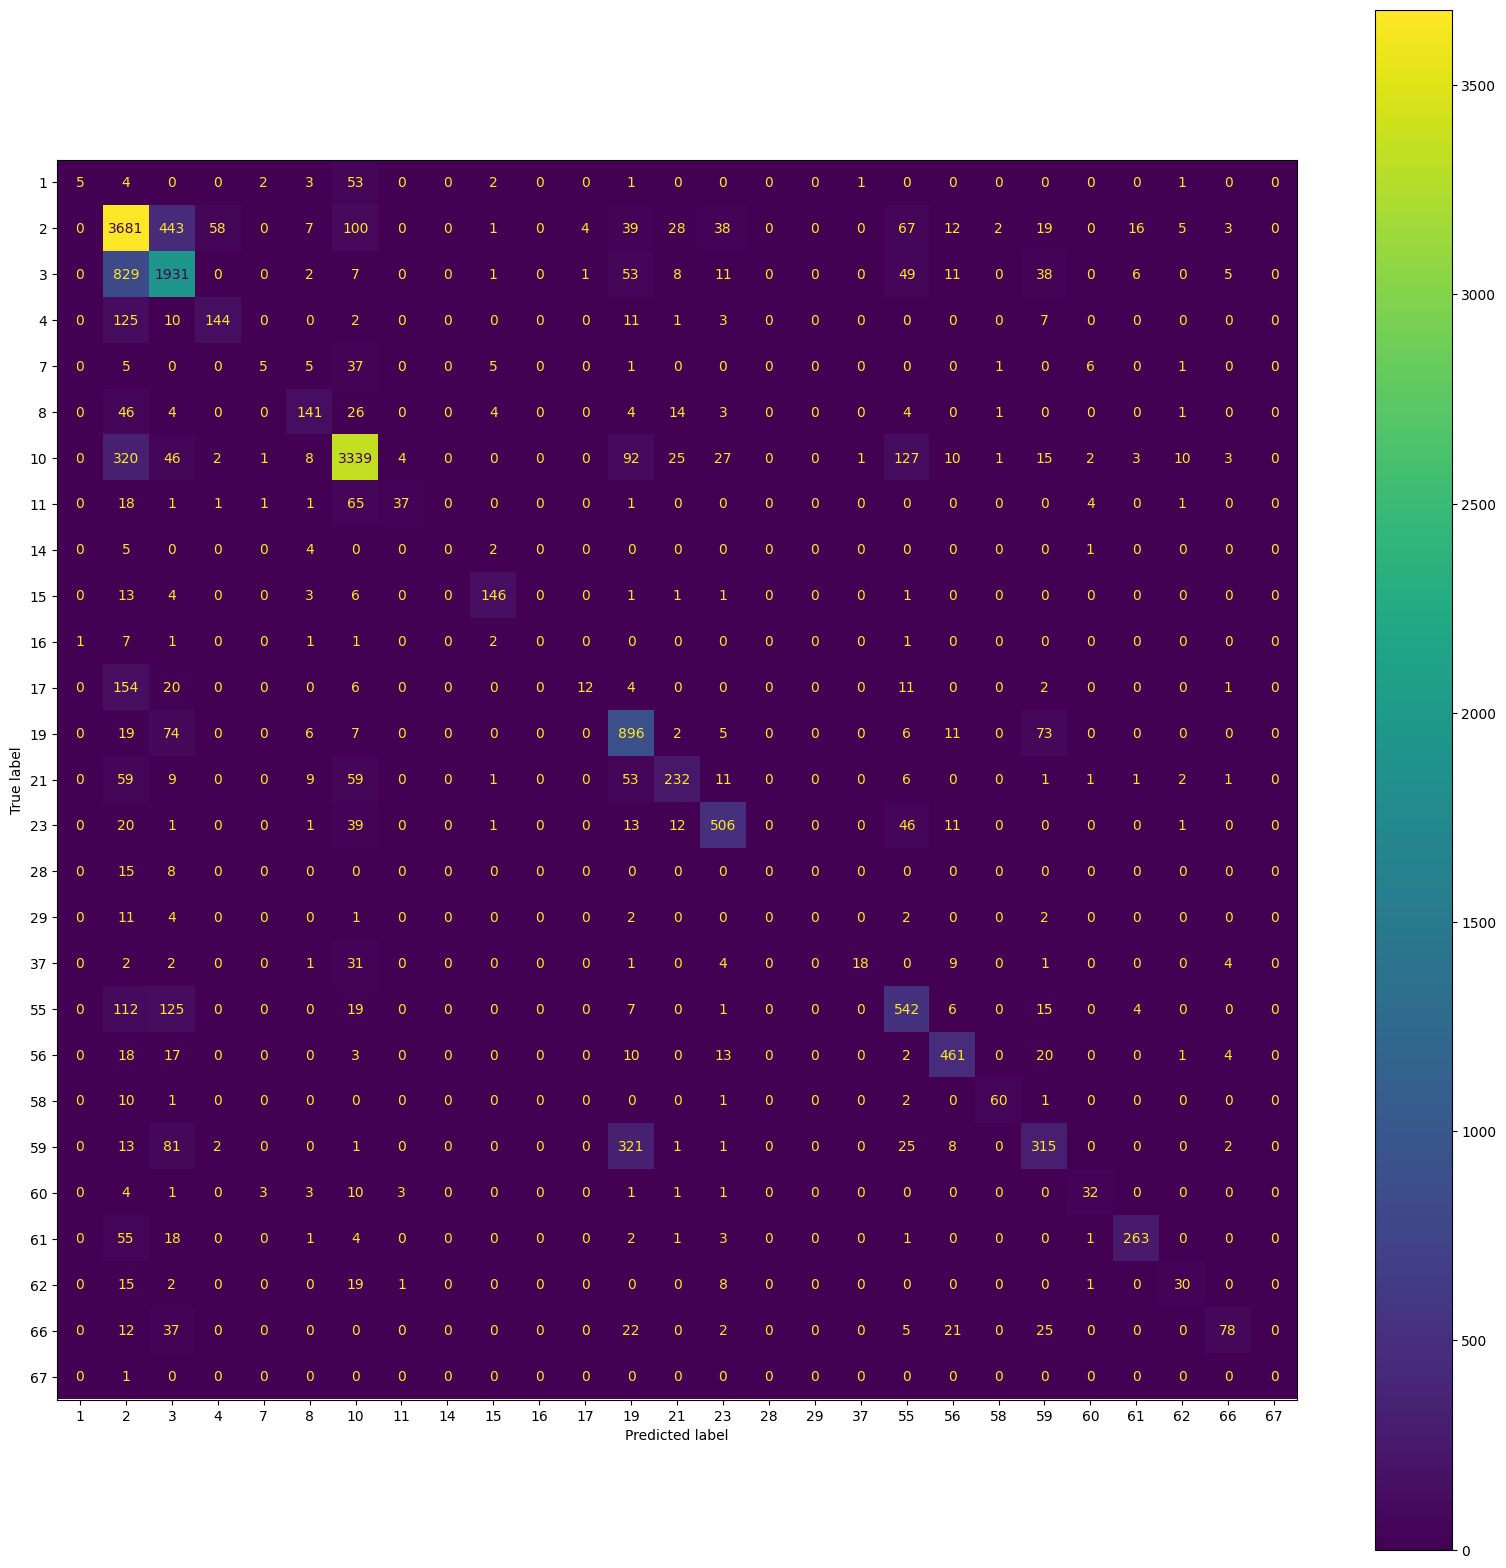

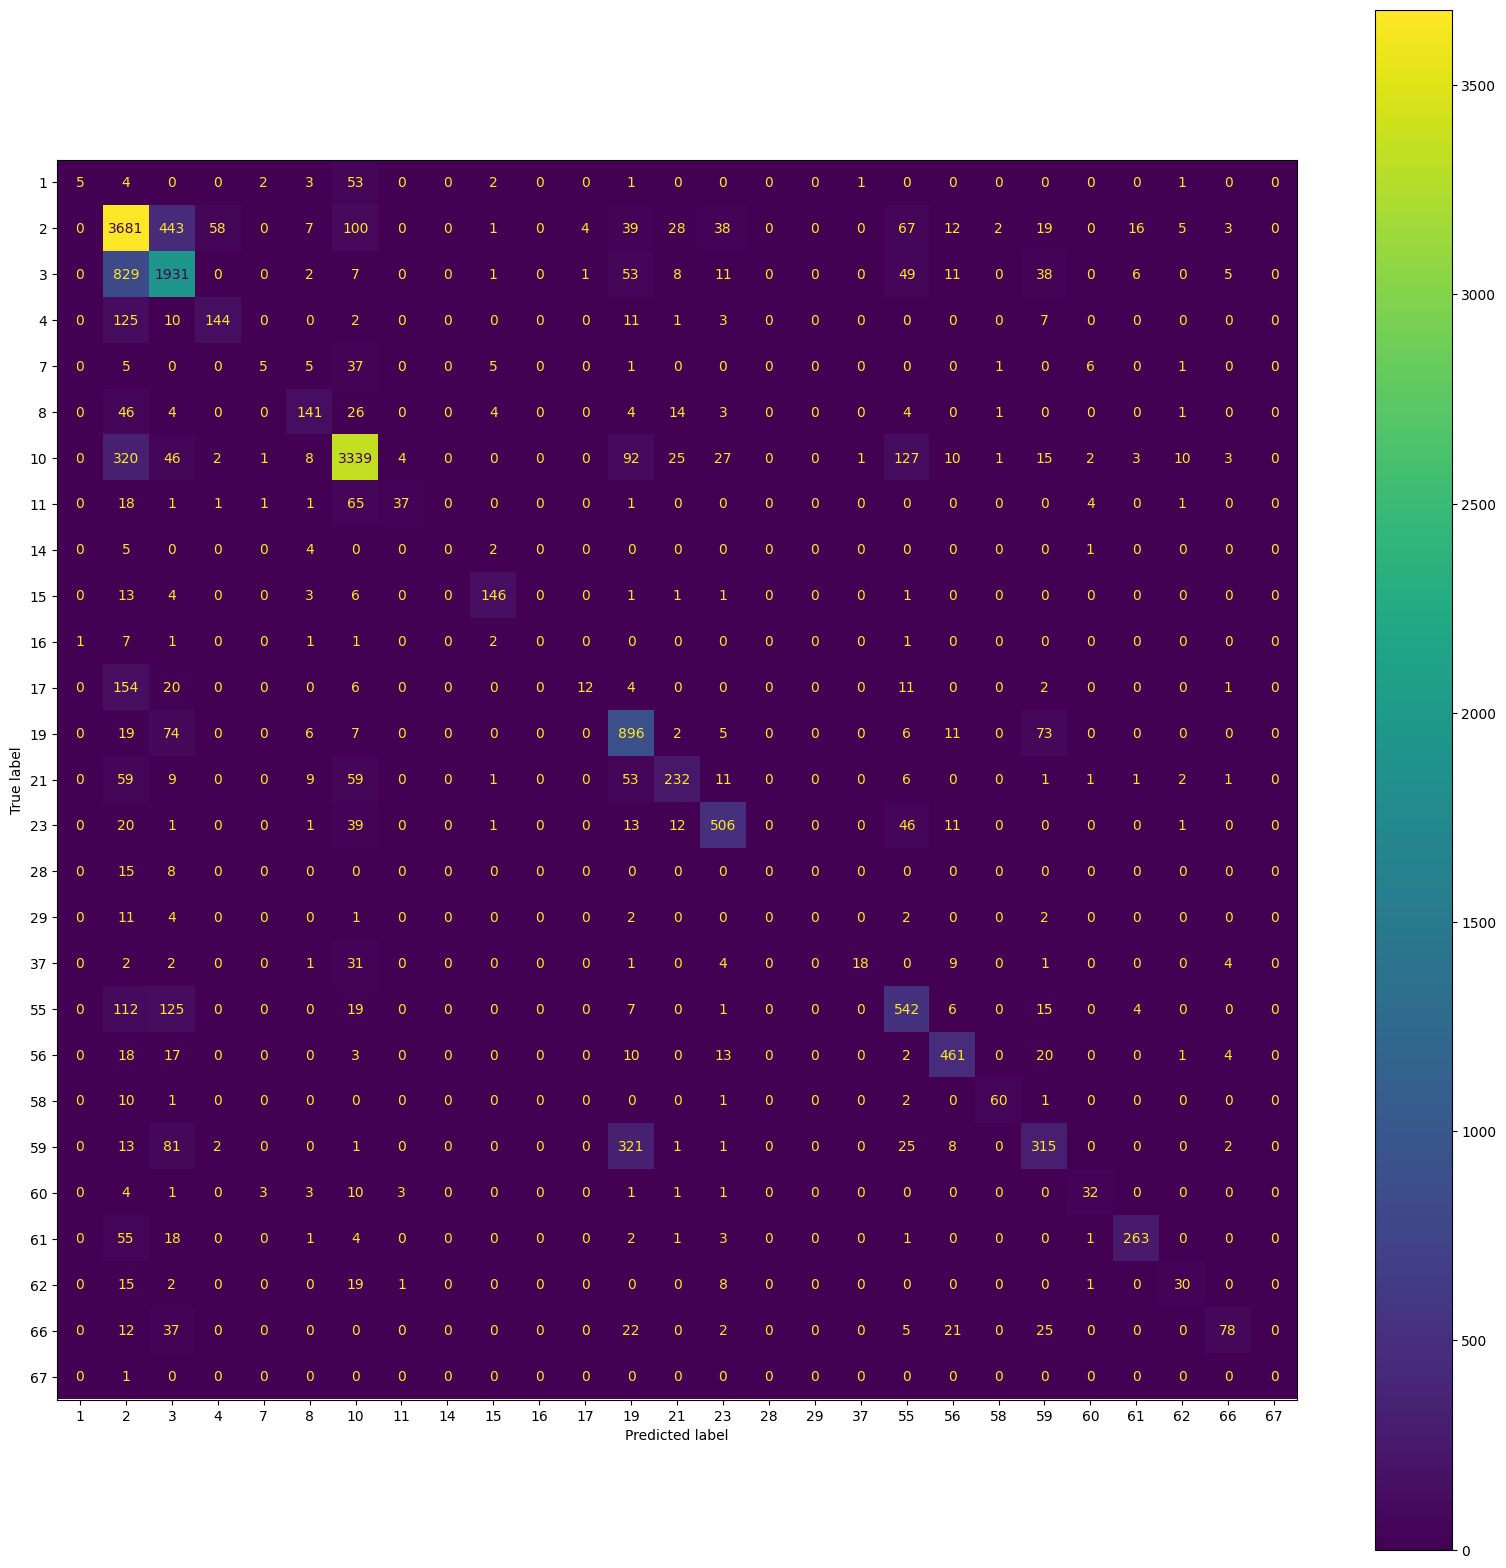

In [12]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
y_unique = y_test.unique()
mcm = multilabel_confusion_matrix(y_test, y_pred, labels = y_unique)
disp = ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test)
disp.plot()

## Отбор признаков

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
df_feats_znach = pd.DataFrame(columns=['feature','pvalue','coef'])
for c in X.columns:
    para=pd.concat((X[c],Y),axis=1)
    para.dropna(inplace=True)
    para.columns=['x','y']
    try:
      model=smf.glm(formula='y~x',data=para,family=sm.families.Binomial()) #использовать sm.Logit для мультиклассовой классификации
      result=model.fit()
      pval=result.pvalues
      coefs=result.params
      if pval[1]<0.05:
          df_feats_znach.loc[len(df_feats_znach)]=[c,pval[1],coefs[1]]
      else:
          continue
    except:
      print(c)

In [ ]:
df_feats_znach.sort_values(by='coef',ascending=True).head(10)

## PCA

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) #рса на два компонента
pca.fit(X) #обучаем
reduced = pca.transform(X)

In [14]:
pca_df=pd.DataFrame(reduced)
pca_df.columns=['x','y']
pca_df['target']=df['category']

In [15]:
import plotly.express as px
fig = px.scatter(pca_df, x="x", y="y", color="target")
fig.update_traces(marker_size=10)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [16]:
titanic = pd.read_csv('/content/drive/MyDrive/Введение в ML ITHUB/lessons/data/titanic.csv')

In [17]:

from sklearn.preprocessing import OneHotEncoder
titanic['Sex']=titanic['Sex'].map({'male':1,'female':0})

#кодирование категориальных признаков [Pclass,Embarked]
def encode_features(df,features):
  df_encode = pd.DataFrame()
  for f in features:
    ohe = OneHotEncoder()
    ohe_arr = ohe.fit_transform(df[[f]])
    ohe_df=pd.DataFrame(ohe_arr.toarray(), columns=ohe.get_feature_names_out())
    df_encode = pd.concat([df_encode,ohe_df],axis=1)
  return df_encode
enc_features = encode_features(titanic,['Pclass','Embarked'])
titanic_df = titanic[['Survived','Sex','Age','SibSp','Parch','Fare']]
titanic_df = pd.concat([titanic_df,enc_features],axis=1)
titanic_df=titanic_df.drop([titanic_df.columns[-1]],axis=1).dropna()

In [18]:
Y = titanic_df['Survived']
X = titanic_df.drop(['Survived'],axis=1)

In [19]:
pca = PCA(n_components=2) #рса на два компонента
pca.fit(X) #обучаем
reduced = pca.transform(X)
pca_df=pd.DataFrame(reduced)
pca_df.columns=['x','y']
pca_df['target']=Y

In [21]:
fig = px.scatter(pca_df, x="x", y="y", color="target")
fig.update_traces(marker_size=10)
fig.show()

## ЛР Классификация

* найти набор данных, для которого МОЖНО РЕШИТЬ ЗАДАЧУ КЛАССИФИКАЦИИ
* выполнить предобработку (если необходимо) и стандартизацию данных
* построить минимум 3 разных модели классификации, используя минимум 2 разных алгоритма классификации
* на основании выбранной вами метрики выбрать лучшую модель
* для лучшей модели отобразить матрицу путаницы

Доп.баллы за перевод в двумерное пространство с помощью PCA  и отрисовку графика